# How to Benchmark Optimization Algorithms

Benchmarking optimization algorithms is an important step when developing a new algorithm or when searching for a algorithm that is good at solving a particular problem. 

In general, benchmarking constists of the following steps:

- Defining the test problems (or getting pre-implemented ones)
- Defining the optimization algorithms and the tuning parameters you want to try
- Running the benchmark
- Plotting the results

Estimagic helps you with all of these steps!

## Get Test Problems

Estimagic includes the problems of [Moré and Wild (2009)](https://doi.org/10.1137/080724083) as well as [Cartis and Roberts](https://arxiv.org/abs/1710.11005).

Each problem consist of the `inputs` (the criterion function and the start parameters) and the `solution` (the optimal parameters and criterion value) and optionally provides more information.

Below we load a subset of the Moré and Wild problems and look at one Rosenbrock problem with difficult start parameters.

In [1]:
from estimagic import get_benchmark_problems

problems = get_benchmark_problems("example")

## Specifying the Optimizers

To select optimizers you want to benchmark on the set of problems, you can simply specify them as a list. Advanced examples that do not only compare algorithms but also vary the `algo_options` can be found below. 

In [2]:
optimizers = [
    "nag_dfols",
    "scipy_neldermead",
    "scipy_truncated_newton",
]

## Running the Benchmark

Once you have your problems and your optimizers, you can simply use `run_benchmark`. The results are a dictionary with one entry for each (problem, algorithm) combination. Each entry not only saves the solution but also the history of the algorithm's criterion and parameter history. 


In [3]:
from estimagic import run_benchmark

results = run_benchmark(
    problems,
    optimizers,
)

## Profile plots

**Profile Plots** compare optimizers over a whole problem set. 

The literature distinguishes **data profiles** and **performance profiles**. Data profiles use a normalized runtime measure whereas performance profile use an absolute one. The profile plot does not normalize runtime by default. To do this, simply set `normalize_runtime` to True. For background information check [Moré and Wild (2009)](https://doi.org/10.1137/080724083). 

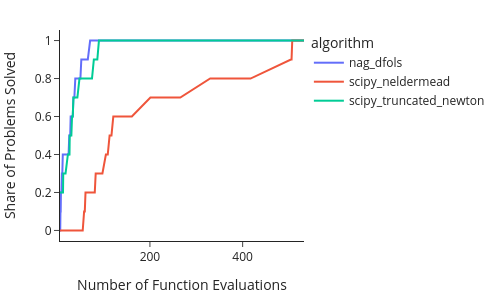

In [4]:
from estimagic import profile_plot

fig = profile_plot(
    problems=problems,
    results=results,
)

fig.show(renderer="png")

The x axis shows runtime per problem. The y axis shows the share of problems each algorithm solved within that runtime. Thus, higher and further to the left values are desirable. Higher means more problems were solved and further to the left means, the algorithm found the solutions earlier. 

You can choose:

- whether to use `n_evaluations` or `walltime` as **`runtime_measure`**
- whether to normalize runtime such that you the runtime of each problem is shown as a multiple of the fastest algorithm on that problem
- how to determine when an evaluation is close enough to the optimum to be counted as converged. Convergence is always based on some measure of distance between the true solution and the solution found by an optimizer. Whether distiance is measured in parameter space, function space or a combination of both can be specified. 

Below, we consider a problem to be solved if the distance between the parameters found by the optimizer and the true solution parameters are at most 0.1% of the distance between the start parameters and true solution parameters. 

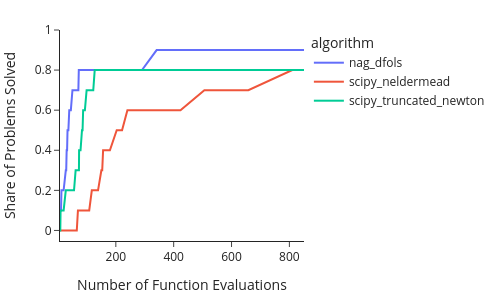

In [6]:
fig = profile_plot(
    problems=problems,
    results=results,
    runtime_measure="n_evaluations",
    stopping_criterion="x",
    x_precision=0.001,
)

fig.show(renderer="png")

## Convergence plots

**Convergence Plots** look at particular problems and show the convergence of each optimizer on each problem. They are similar to what you know from the dashboard.

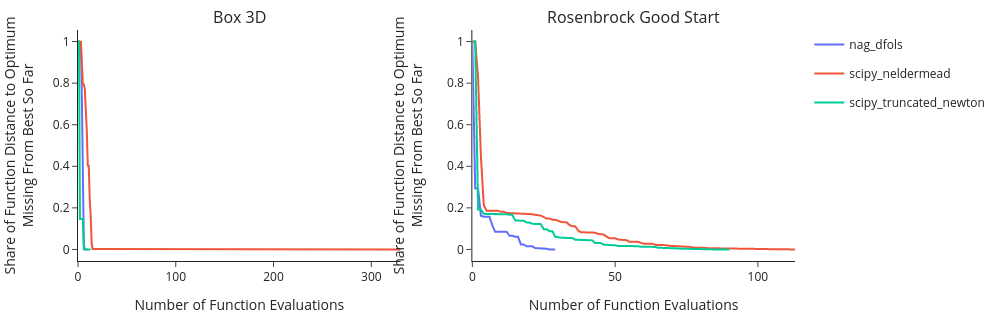

In [8]:
from estimagic import convergence_plot

fig = convergence_plot(
    problems=problems,
    results=results,
    n_cols=2,
    problem_subset=["rosenbrock_good_start", "box_3d"],
)

fig.show(renderer="png")

The further to the left and the lower the curve of an algorithm the better that algorithm performed.

Often we are more interested in how close each algorithm got to the true solution in parameter space, not in criterion space as above. For this we simply set the **`distance_measure`** to `parameter_space`. 

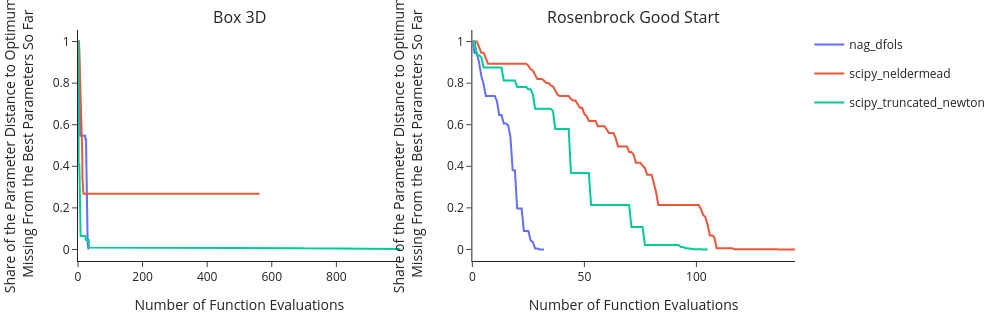

In [9]:
fig = convergence_plot(
    problems=problems,
    results=results,
    n_cols=2,
    problem_subset=["rosenbrock_good_start", "box_3d"],
    distance_measure="parameter_distance",
    stopping_criterion="x",
)

fig.show(renderer="png")